In [1]:
from HeaderP import *

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


In [255]:
# from So
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
import requests
from os.path import exists
import os
def download_ztf_archive_lightcurves(ra, dec, objids=[], sr=0.001, lcout=False):
    ra = str(ra)
    dec = str(dec)
    sr = str(sr)
    
    url1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE "
    url2 = f"{ra} {dec} {sr}&BANDNAME=r&NOBS_MIN=30&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table"
    url = url1 + url2


    r = requests.get(url)

    urlData = r.content

    mainlc = pd.read_table(io.StringIO(urlData.decode('utf-8')),
                          delim_whitespace=True, skiprows=54, names=colnames)

    return mainlc
    

In [51]:
import io
import os
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

def fitpoly(t,mag):
    p = fitpoints(t,mag,2)
    return t, mag-p(t)



def movingMed_time(t, mag, T_window,delta_T_window):
    # add in two columns for the median and put Nan's in them
    t_med=np.empty(len(mag))
    mag_med=np.empty(len(mag))
    t_med[:]=np.nan
    mag_med[:]=np.nan
    
    # define the boundaries of the windows
    window_min=float(min(t))
    window_max=float(window_min+delta_T_window)
    # max time
    maxtime=max(t)
    # break when time window hits the end
    while window_max<=maxtime+T_window:
        seldf=((t>=window_min) & (t<=window_max)) # get points between the window
        
        t_med[seldf]=np.median(t[seldf]) # all values for these indices are subsituded with median time
        mag_med[seldf]=np.median(mag[seldf]) # all values for these indices are subsituded with median flux

        window_min=window_min+delta_T_window
        window_max=window_max+delta_T_window
    return t_med, mag_med




# Get Mearth data

In [583]:
from astropy.io import ascii
table = ascii.read("mearthRADEC")
radec = table.to_pandas()

In [6]:
radec = radec.loc[(radec['Type']=='A')|(radec['Type']=='B')].reset_index(drop=True)
radec = radec.loc[radec['DEdeg']>0].reset_index(drop=True)
radec['ra'] = radec['RAdeg']
radec['dec'] = radec['DEdeg']
len(radec)

387

In [586]:
max(radec['P'])

1500.0

In [386]:
import io
import os
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

def fitpoly(t,mag):
    p = fitpoints(t,mag,2)
    return t, mag-p(t)



def movingMed_time(t, mag, T_window,delta_T_window):
    # add in two columns for the median and put Nan's in them
    t_med=np.empty(len(mag))
    mag_med=np.empty(len(mag))
    t_med[:]=np.nan
    mag_med[:]=np.nan
    
    # define the boundaries of the windows
    window_min=float(min(t))
    window_max=float(window_min+delta_T_window)
    # max time
    maxtime=max(t)
    # break when time window hits the end
    while window_max<=maxtime+T_window:
        seldf=((t>=window_min) & (t<=window_max)) # get points between the window
        
        t_med[seldf]=np.median(t[seldf]) # all values for these indices are subsituded with median time
        mag_med[seldf]=np.median(mag[seldf]) # all values for these indices are subsituded with median flux

        window_min=window_min+delta_T_window
        window_max=window_max+delta_T_window
    return t_med, mag_med

def processlc(maincord, searchradius=5, magrange=1, pltorg=False, splitlc=True, autls=True,
             protmeas=np.linspace(1,200,500),savefigname=[]):
    # search radius is arcmin
    colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
    
    mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'][0]].reset_index(drop=True)
    mainlc = mainlc.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    mainlc = mainlc.loc[mainlc['airmass']<1.8].reset_index(drop=True)
    mainlc = mainlc.loc[mainlc['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    mainlc = mainlc[['oid','mjd','mag','magerr']]
    
    
    lcs = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=searchradius/60, lcout=True)
    lcs = lcs.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    lcs = lcs.loc[lcs['airmass']<1.8].reset_index(drop=True)
    lcs = lcs.loc[lcs['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    lcs = lcs[['oid','mjd','mag','magerr']]
    
    nearlcs = lcs.loc[~lcs['oid'].isin(mainlc['oid'].unique())].reset_index(drop=True)
    m = abs(nearlcs['mag']-np.median(mainlc['mag']))<magrange
    nearlcs = nearlcs[m].reset_index(drop=True)
    nearlc_ids = nearlcs['oid'].unique()
    nearbylcs_no = len(nearlc_ids)
    #print('There are nearby %d lcs...'%(nearbylcs_no))
    
    mags = nearlcs['mag']
    for i in trange(nearbylcs_no):
        m = (nearlcs['oid'] == nearlc_ids[i])
        mags[m] = mags[m]-np.median(mags[m])
        
    nearlcs['mag'] = mags
    
    
    normtime = min(mainlc['mjd'].values)
    
    lctime = mainlc['mjd'].values-min(mainlc['mjd'].values)
    lcmags = mainlc['mag'].values
    lcmags_err = mainlc['magerr'].values
    
    
    if pltorg:
        print('LG orginal lcs...')
        plt.figure(figsize=(30,16))
        plt.subplot(2,3,1)
        plt.plot(lctime, lcmags, 'ro', markersize=10, label='pre process')
        plt.xlabel('Time [days]')
        plt.ylabel('Magnitude')
        plt.ylim([min(lcmags),max(lcmags)])
        plt.gca().invert_yaxis()
        plt.title('Origenal lc',fontsize=25)
        

        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
        plt.subplot(2,3,2)
        P = 1/best_frequency
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
        plt.plot(t_fold,  lcmags, 'ko', markersize=10)   
        t_fold, mag = zip(*sorted(zip(t_fold, lcmags)))
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.tight_layout()
        plt.ylim([min(lcmags),max(lcmags)])
        plt.title('Prot = %.2f days'%(P.value), fontsize=25)
        plt.gca().invert_yaxis()
        
        plt.subplot(2,3,3)
        plt.semilogx(1/frequency, power, 'k-')   
        plt.xlim(1,200)
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.ylim([0,max(power)])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()       
    else:
        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
    """
    timediff = np.append([0], np.diff(lctime))
    m = (timediff>0.003)|(timediff==0)
    lctime, lcmags, lcmags_err = lctime[m], lcmags[m], lcmags_err[m]
    """
    timediff = np.append([0], np.diff(lctime))
    if splitlc:
        splits_m = (timediff>60)
        numb_splits = int(sum(splits_m))
        splittimes = lctime[splits_m]
        #print('splitting into %d lcs...'%(numb_splits+1))
        if (numb_splits)==0:
            #print('no lc to split...')
            splitlc=False
        
    
    lcmags = lcmags-np.median(lcmags)
     
    nearlc_time = nearlcs['mjd'].values-min(mainlc['mjd'].values)
    nearlc_mag = nearlcs['mag'].values
    
    lcmags_new = np.zeros(len(lctime))
    for i in range(len(lctime)):
        m = (nearlc_time == lctime[i])
        if sum(m)==0:
            lcmags_new[i] = lcmags[i]
        else:
            lcmags_new[i] = lcmags[i]-np.median(nearlc_mag[m])
    lcmags_new = lcmags_new-np.median(lcmags_new)
    
    if splitlc:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        for i in range(-1, numb_splits+1):
            if i==0:
                msplit = (lctime<splittimes[0])
            elif i==(numb_splits):
                msplit = (lctime>=splittimes[i-1])
            elif i==-1:
                msplit = (lctime>0)
            else:
                msplit = (lctime>=splittimes[i-1])&(lctime<splittimes[i])

            
            if sum(msplit)<30:
                continue
            # split into single season + overall ones
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime[msplit], lcmags_new[msplit], lcmags_err[msplit]
            
            # get rid of outliers
            good_ind = abs(lcmags_new_sing1-np.median(lcmags_new_sing1))<3*np.std(lcmags_new_sing1)
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime_sing1[good_ind], lcmags_new_sing1[good_ind], lcmags_err_sing1[good_ind]
            
            # 
            lctime_sing.append(lctime_sing1)
            lcmags_sing.append(lcmags_new_sing1-np.median(lcmags_new_sing1)) 
            lcmags_err_sing.append(lcmags_err_sing1)
        #print('splitting into %d lcs...'%(len(lctime_sing)))
            
    else:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        good_ind = abs(lcmags_new-np.median(lcmags_new))<3*np.std(lcmags_new)
        lctime_sing.append(lctime[good_ind])
        lcmags_sing.append(lcmags_new[good_ind]-np.median(lcmags_new[good_ind])) 
        lcmags_err_sing.append(lcmags_err[good_ind])
        
        
    if pltorg:
        #print('LG post processed lcs...')
        plt.subplot(2,3,4)
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            plt.plot(lctime_sing[i], lcmags_sing[i], 'o', markersize=10)
            plt.xlabel('Time [days]')
            plt.ylabel('normaized magnitude (post)')
            minyylim = min([minyylim, min(lcmags_sing[i])])
            maxylim = max([maxylim, max(lcmags_sing[i])])
        plt.ylim([minyylim, maxylim])
        plt.gca().invert_yaxis()
        plt.title('Processed lc',fontsize=25)
        
        plt.subplot(2,3,5)
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            if autls:
                timerange = 1/((max(lctime_sing[i])-min(lctime_sing[i]))/2)
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag).autopower(minimum_frequency=timerange*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                    lcmags_err_sing[i]* u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            plt.plot(t_fold/(max(t_fold)-min(t_fold)),  lcmags_sing[i]+0.1*i, 'o', label='Prot=%.2f'%P.value, markersize=10)   
            minyylim = min([minyylim, min(lcmags_sing[i]+0.1*i)])
            maxylim = max([maxylim, max(lcmags_sing[i]+0.1*i)])
            plt.xlabel('Normalized Time [Day]')
            plt.ylabel('Power')
            plt.tight_layout()
            
        
        plt.legend()
        plt.ylim([minyylim-0.05,maxylim+0.05])
        plt.gca().invert_yaxis()
        
        
        plt.subplot(2,3,6)
        maxpower = 0
        for i in range(len(lctime_sing)):
            plt.semilogx(1/frequency[i], power[i], '-')   
            plt.xlim(0,200)
            plt.xlabel('Period [Day]')
            plt.ylabel('Power')
            maxpower = max([maxpower, max(power[i])])
        plt.ylim([0,maxpower])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()
        if len(savefigname)!=0:
            plt.savefig(savefigname)
            plt.close()
        
        
    else:
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        for i in range(len(lctime_sing)):
            if autls:
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag).autopower(minimum_frequency=0.005*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                    lcmags_err_sing[i]* u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            t_fold, mag = zip(*sorted(zip(t_fold, lcmags_sing[i])))
            
        
    t3 = time.perf_counter()
    
    #if splitlc:
    #    return lctime, lcmags, [i.value for i in Ps], [i.value for i in bestpower], t2-t1, t3-t2

    #else:
    #    return lctime, lcmags, [i.value for i in Ps][0], [i.value for i in bestpower][0], t2-t1, t3-t2
    return lctime_sing, lcmags_sing, normtime, nearbylcs_no

 
        



In [8]:
gaiaid = pd.read_csv('MEarth_Rotator_List_v2.csv')

In [599]:
def ls_multi(gaiaid, normalizetime=None, pltorg=False, splitlc=True, autls=True,
             protmeas=np.linspace(1,200,500)):
    filename = 'LC_Jason/Gaia_EDR3-'+str(gaiaid)+'-ZTF_r.csv'
    
    mainlc = pd.read_csv(filename, names=['time', 'mag','filter'])

    lctime = mainlc['time'].values+5e4
    if normalizetime!=None:
        lctime = lctime - normalizetime
    else:
        lctime = lctime-min(lctime)
    lcmags = mainlc['mag'].values
    
    good_ind = abs(lcmags-np.median(lcmags))<3*np.std(lcmags)
    lctime, lcmags = lctime[good_ind], lcmags[good_ind]
        
        
    timediff = np.append([0], np.diff(lctime))
    if splitlc:
        splits_m = (timediff>60)
        numb_splits = int(sum(splits_m))
        splittimes = lctime[splits_m]
        if (numb_splits)==0:
            splitlc=False
    
    
    if splitlc:
        lctime_sing, lcmags_sing = [], []
        for i in range(-1, numb_splits+1):
            if i==0:
                msplit = (lctime<splittimes[0])
            elif i==(numb_splits):
                msplit = (lctime>=splittimes[i-1])
            elif i==-1:
                msplit = (lctime>0)
            else:
                msplit = (lctime>=splittimes[i-1])&(lctime<splittimes[i])
            
            if sum(msplit)<30:
                continue

            lctime_sing1, lcmags_new_sing1 = lctime[msplit], lcmags[msplit]
            
            # 
            lctime_sing.append(lctime_sing1)
            lcmags_sing.append(lcmags_new_sing1) 

        print('splitting into %d lcs...'%(len(lctime_sing)))
            
    else:
        lctime_sing, lcmags_sing = [], []
        lctime_sing.append(lctime)
        lcmags_sing.append(lcmags) 
        
    plt.figure(figsize=(30,8))
    if pltorg:
        print('LG post processed lcs...')
        plt.subplot(1,3,1)
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            plt.plot(lctime_sing[i], lcmags_sing[i], 'o', markersize=10)
            plt.xlabel('Time [days]')
            plt.ylabel('normaized magnitude (post)')
            minyylim = min([minyylim, min(lcmags_sing[i])])
            maxylim = max([maxylim, max(lcmags_sing[i])])
        try:
            plt.ylim([minyylim, maxylim])
        except:
            print('no ylim')
        plt.gca().invert_yaxis()
        plt.title('lc',fontsize=25)
        
        plt.subplot(1,3,2)
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            if autls:
                timerange = 1/((max(lctime_sing[i])-min(lctime_sing[i]))/2)
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag).autopower(minimum_frequency=timerange*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            plt.plot(t_fold/(max(t_fold)-min(t_fold)),  lcmags_sing[i]+0.1*i, 'o', label='Prot=%.2f'%P.value, markersize=10)   
            minyylim = min([minyylim, min(lcmags_sing[i]+0.1*i)])
            maxylim = max([maxylim, max(lcmags_sing[i]+0.1*i)])
            plt.xlabel('Normalized Time [Day]')
            plt.ylabel('Power')
            plt.tight_layout()
            
        
        plt.legend()
        try:
            plt.ylim([minyylim-0.001,maxylim+0.001])
        except:
            print('no ylim')
        plt.gca().invert_yaxis()
        
        
        plt.subplot(1,3,3)
        maxpower = 0
        for i in range(len(lctime_sing)):
            plt.semilogx(1/frequency[i], power[i], '-')   
            plt.xlim(0,200)
            plt.xlabel('Period [Day]')
            plt.ylabel('Power')
            maxpower = max([maxpower, max(power[i])])
        plt.ylim([0,maxpower])
        plt.title('id = '+str(gaiaid),fontsize=25)
        plt.tight_layout()

        
        
    else:
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        for i in range(len(lctime_sing)):
            if autls:
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag).autopower(minimum_frequency=0.005*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            t_fold, mag = zip(*sorted(zip(t_fold, lcmags_sing[i])))
            
    try:
        medpower = [i.value for i in medpower]
    except:
        medpower = [np.nan for i in medpower]
    
    try:
        Ps = [i.value for i in Ps]
    except:
        Ps = [np.nan for i in medpower]
        
    try:
        bestpower = [i.value for i in bestpower]
    except:
        bestpower = [np.nan for i in bestpower]
        
    
    return lctime_sing, lcmags_sing, Ps, bestpower, medpower



def ls_orginal(maincord, normalizetime=None, pltorg=False, splitlc=True, autls=True,
             protmeas=np.linspace(1,200,500)):
    
    colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
    
    mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'][0]].reset_index(drop=True)
    mainlc = mainlc.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    mainlc = mainlc.loc[mainlc['airmass']<1.8].reset_index(drop=True)
    mainlc = mainlc.loc[mainlc['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    mainlc = mainlc[['oid','mjd','mag','magerr']]
    
    lctime = mainlc['mjd'].values
    
    if normalizetime!=None:
        lctime = lctime - normalizetime
    else:
        lctime = lctime-min(lctime)
    lcmags = mainlc['mag'].values
    
    good_ind = abs(lcmags-np.median(lcmags))<3*np.std(lcmags)
    lctime, lcmags = lctime[good_ind], lcmags[good_ind]
        
        
    timediff = np.append([0], np.diff(lctime))
    if splitlc:
        splits_m = (timediff>60)
        numb_splits = int(sum(splits_m))
        splittimes = lctime[splits_m]
        if (numb_splits)==0:
            splitlc=False
    
    
    if splitlc:
        lctime_sing, lcmags_sing = [], []
        for i in range(-1, numb_splits+1):
            if i==0:
                msplit = (lctime<splittimes[0])
            elif i==(numb_splits):
                msplit = (lctime>=splittimes[i-1])
            elif i==-1:
                msplit = (lctime>0)
            else:
                msplit = (lctime>=splittimes[i-1])&(lctime<splittimes[i])
            
            if sum(msplit)<30:
                continue

            lctime_sing1, lcmags_new_sing1 = lctime[msplit], lcmags[msplit]
            
            # 
            lctime_sing.append(lctime_sing1)
            lcmags_sing.append(lcmags_new_sing1) 

        print('splitting into %d lcs...'%(len(lctime_sing)))
            
    else:
        lctime_sing, lcmags_sing = [], []
        lctime_sing.append(lctime)
        lcmags_sing.append(lcmags) 
        
    plt.figure(figsize=(30,8))
    if pltorg:
        print('LG post processed lcs...')
        plt.subplot(1,3,1)
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            plt.plot(lctime_sing[i], lcmags_sing[i], 'o', markersize=10)
            plt.xlabel('Time [days]')
            plt.ylabel('normaized magnitude (post)')
            minyylim = min([minyylim, min(lcmags_sing[i])])
            maxylim = max([maxylim, max(lcmags_sing[i])])
        try:
            plt.ylim([minyylim, maxylim])
        except:
            print('no ylim')
        plt.gca().invert_yaxis()
        plt.title('lc',fontsize=25)
        
        plt.subplot(1,3,2)
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            if autls:
                timerange = 1/((max(lctime_sing[i])-min(lctime_sing[i]))/2)
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag).autopower(minimum_frequency=timerange*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            plt.plot(t_fold/(max(t_fold)-min(t_fold)),  lcmags_sing[i]+0.1*i, 'o', label='Prot=%.2f'%P.value, markersize=10)   
            minyylim = min([minyylim, min(lcmags_sing[i]+0.1*i)])
            maxylim = max([maxylim, max(lcmags_sing[i]+0.1*i)])
            plt.xlabel('Normalized Time [Day]')
            plt.ylabel('Power')
            plt.tight_layout()
            
        
        plt.legend()
        try:
            plt.ylim([minyylim-0.001,maxylim+0.001])
        except:
            print('no ylim')
        plt.gca().invert_yaxis()
        
        
        plt.subplot(1,3,3)
        maxpower = 0
        for i in range(len(lctime_sing)):
            plt.semilogx(1/frequency[i], power[i], '-')   
            plt.xlim(0,200)
            plt.xlabel('Period [Day]')
            plt.ylabel('Power')
            maxpower = max([maxpower, max(power[i])])
        plt.ylim([0,maxpower])
        #plt.title('id = '+str(gaiaid),fontsize=25)
        plt.tight_layout()

        
        
    else:
        frequency, power, bestfreq, bestpower, Ps, medpower = [], [], [], [], [], []
        for i in range(len(lctime_sing)):
            if autls:
                frequency_1, power_1 = LombScargle(lctime_sing[i] * u.day, 
                                                   lcmags_sing[i] * u.mag).autopower(minimum_frequency=0.005*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag).power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            t_fold, mag = zip(*sorted(zip(t_fold, lcmags_sing[i])))
            
    try:
        medpower = [i.value for i in medpower]
    except:
        medpower = [np.nan for i in medpower]
    
    try:
        Ps = [i.value for i in Ps]
    except:
        Ps = [np.nan for i in medpower]
        
    try:
        bestpower = [i.value for i in bestpower]
    except:
        bestpower = [np.nan for i in bestpower]
        
    
    return lctime_sing, lcmags_sing, Ps, bestpower, medpower

In [10]:
allids = [i.split('-')[1] for i in os.listdir('LC_Jason/') if 'Gaia' in i]
len(allids)

288

In [ ]:
filename = 'ztfProts_split_jason'
f = open(filename, 'w+')
f.write('gaiadr3,prot1,prot2,prot3,prot4,prot5,prot6,prot7,maxpower1,maxpower2,maxpower3,maxpower4,maxpower5,maxpower6,maxpower7,medpower1,medpower2,medpower3,medpower4,medpower5,medpower6,medpower7\n')
f.flush()

from IPython.display import clear_output
for i in trange(len(allids)):
    
    clear_output(wait=True)
    filename = 'LC_Jason/Gaia_EDR3-'+str(allids[i])+'-ZTF_r.csv'
    
    mainlc = pd.read_csv(filename, names=['time', 'mag','filter'])
    
    if len(mainlc)<30:
        continue
    
    if len(mainlc)<100:
        lctime, lcmags, p, maxpower, medpower = ls_multi(allids[i], 
                  pltorg=True, splitlc=False)

    else:
        lctime, lcmags, p, maxpower, medpower= ls_multi(allids[i], 
               pltorg=True)


    fline = str(allids[i])
    for j in range(7):
        try:
            fline = fline+','+str(p[j])
        except:
            fline = fline+','+'nan'
    for j in range(7):
        try:
            fline = fline+','+str(maxpower[j])
        except:
            fline = fline+','+'nan'
    for j in range(7):
        try:
            fline = fline+','+str(medpower[j])
        except:
            fline = fline+','+'nan'
    f.write(fline+'\n')
    f.flush()
    


In [23]:
prots = pd.read_table('ztfProts_split_jason',delimiter=',')
print(len(prots))
prots = pd.merge(gaiaid, prots, left_on='Gaia_EDR3_ID', right_on='gaiadr3',how='inner')
print(len(prots))

288
288


In [24]:
prots

,2MASS,Gaia_DR2_ID,Gaia_EDR3_ID,Prot,Amp,e_Amp,Prot_Type,RA,Dec,BP-RP,...,maxpower5,maxpower6,maxpower7,medpower1,medpower2,medpower3,medpower4,medpower5,medpower6,medpower7
0,J00011579+0659355,2745860763717896448,2745860763717896448,20.480,0.0062,0.0022,A,0.313972,6.992824,3.439976,...,0.290295,NaN,NaN,0.004964,0.012321,0.033464,0.028348,0.038317,NaN,NaN
1,J00151880+4344347,385502112574538624,385502112574538624,1.427,0.0114,0.0021,A,3.829797,43.743120,3.022393,...,NaN,NaN,NaN,0.005860,NaN,NaN,NaN,NaN,NaN,NaN
2,J00185352+2748499,2856874535763703680,2856874535763703680,6.049,0.0088,0.0015,A,4.725288,27.813356,2.861120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J00240376+2626299,2855743172658367360,2855743172658367360,29.840,0.0088,0.0023,A,6.016508,26.441353,2.950496,...,0.475046,NaN,NaN,0.003668,0.010794,0.017864,0.009052,0.022660,NaN,NaN
4,J00243478+3002295,2859027409595355776,2859027409595355776,1.077,0.0089,0.0015,A,6.148344,30.041582,3.120290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,J23270216+2710367,2865785527751748992,2865785527751748992,0.922,0.0043,0.0024,B,351.759644,27.177299,2.962286,...,NaN,NaN,NaN,0.004433,0.017678,0.007605,0.020236,NaN,NaN,NaN
284,J23310587+0842314,2761293783802549760,2761293783802549760,1.647,0.0182,0.0035,B,352.775448,8.709099,2.631259,...,0.765899,NaN,NaN,0.004708,0.027787,0.011711,0.017235,0.025651,NaN,NaN
285,J23354132+0611205,2756552552224710912,2756552552224710912,1.671,0.0057,0.0048,B,353.924668,6.190257,3.293031,...,0.163470,NaN,NaN,0.005373,0.011915,0.045292,0.016300,0.043751,NaN,NaN
286,J23505402+3829334,2881491570317649920,2881491570317649920,73.030,0.0052,0.0020,B,357.724627,38.491706,2.872758,...,NaN,NaN,NaN,0.002145,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for i in range(1,8):
    prots['SN'+str(i)]=prots['maxpower'+str(i)]/prots['medpower'+str(i)]

In [26]:
bestid = prots['gaiadr3'].values
bestprot = np.zeros(len(prots))
bestsn = np.zeros(len(prots))

In [35]:
for i in trange(len(bestid)):
    prots_sing = prots.iloc[i]
    allsn = np.array([prots_sing['SN'+str(j)] for j in range(1,8)])
    allsn = allsn[allsn==allsn]
    try:
        bestprot[i] = prots_sing['prot'+str(np.argmax(allsn)+1)]
        bestsn[i] = min(allsn)
    except:
        bestsn[i] = prots_sing['prot1']

100%|██████████| 288/288 [00:00<00:00, 5292.64it/s]


In [36]:
prots['bestprot'] = bestprot
prots['bestSN'] = bestsn

36 288 0.125


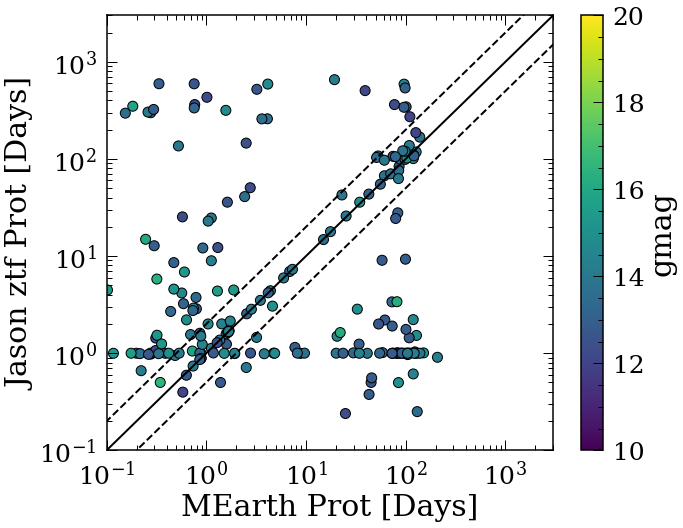

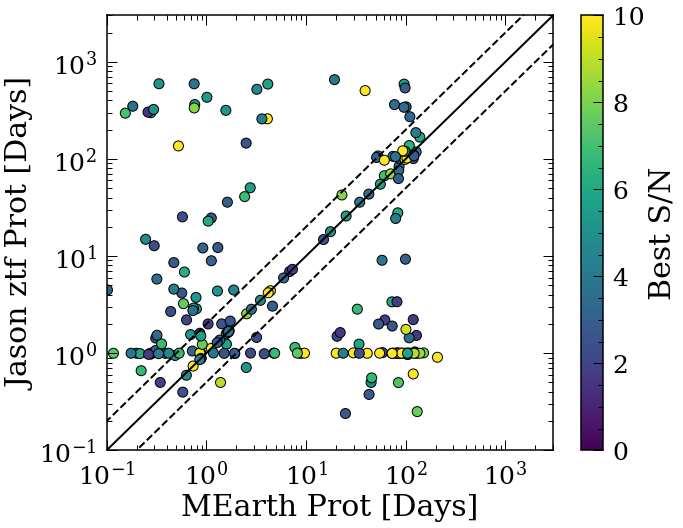

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(prots['Prot'], prots['bestprot'], c=prots['Gmag'], s=100, 
            edgecolor='k', vmin=10, vmax=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('Jason ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure(figsize=(10,8))
plt.scatter(prots['Prot'], prots['bestprot'], c=prots['bestSN'], s=100, 
            edgecolor='k',vmin=0,vmax=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('Jason ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Best S/N')

goodp = (abs(prots['bestprot']-prots['Prot'])/prots['Prot'])<0.1

print(sum(goodp), len(prots), sum(goodp)/len(prots))

In [45]:
df_cm = prots

goodp = (abs(df_cm['bestprot']-df_cm['Prot'])/df_cm['Prot'])<0.1

print('Best period:', sum(goodp), len(df_cm), sum(goodp)/len(df_cm))


df_cm['overall1'] = (abs(df_cm['prot1']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall2'] = (abs(df_cm['prot2']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall3'] = (abs(df_cm['prot3']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall4'] = (abs(df_cm['prot4']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall5'] = (abs(df_cm['prot5']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall6'] = (abs(df_cm['prot6']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall7'] = (abs(df_cm['prot7']-df_cm['Prot'])/df_cm['Prot'])<0.1
goodp = (abs(df_cm['prot1']-df_cm['Prot'])/df_cm['Prot'])<0.1
goodp = goodp|((abs(df_cm['prot2']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot3']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot4']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot5']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot6']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot7']-df_cm['Prot'])/df_cm['Prot'])<0.1)
df_cm['overall'] = goodp
print(sum(df_cm['overall1']),sum(df_cm['overall2']),sum(df_cm['overall3']),
      sum(df_cm['overall4']),sum(df_cm['overall5']),sum(df_cm['overall6']),
     sum(df_cm['overall7']))
print(sum(goodp), sum(goodp)/len(df_cm))



    

Best period: 36 288 0.125
22 25 30 35 13 0 0
74 0.2569444444444444


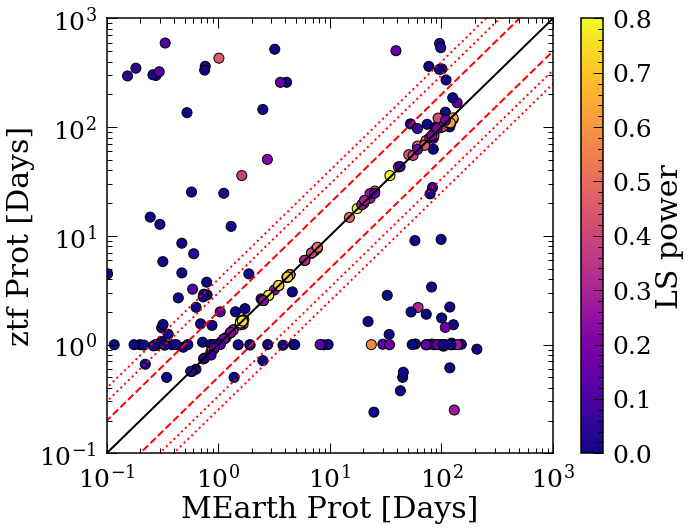

In [59]:
import matplotlib.colors
def getcolor(vrange,cm=plt.cm.get_cmap('jet')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
colors = getcolor(np.array([1,2,3,4,5,6]),plt.cm.get_cmap('plasma'))

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
prots_pag = df_cm.loc[df_cm['overall']==0]
plt.scatter(prots_pag['Prot'], prots_pag['bestprot'], c=prots_pag['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0.1, vmax=0.8)

for i in range(1,6):
    prots_pag = df_cm.loc[df_cm['overall'+str(i)]==1]
    plt.scatter(prots_pag['Prot'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')

73

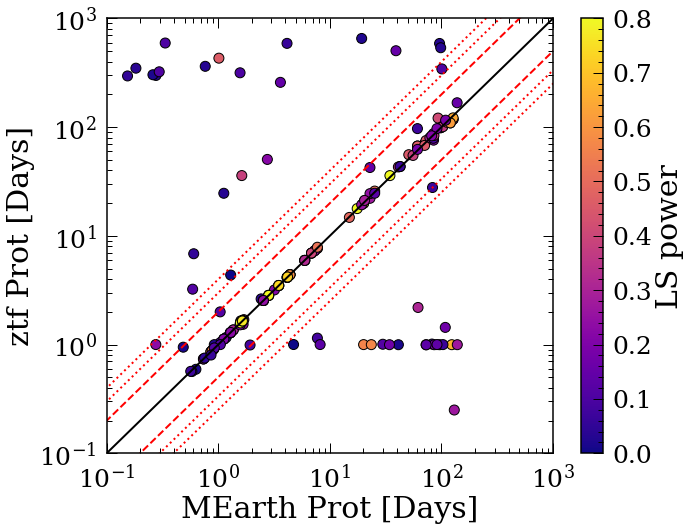

In [68]:
# cut 0.1 LS power
import matplotlib.colors
protcut = 0.1
df_cm_cut = df_cm.loc[df_cm['maxpower1']>protcut].reset_index(drop=True)
def getcolor(vrange,cm=plt.cm.get_cmap('jet')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
colors = getcolor(np.array([1,2,3,4,5,6]),plt.cm.get_cmap('plasma'))

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
plt.scatter(df_cm_cut['Prot'], df_cm_cut['bestprot'], c=df_cm_cut['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0.1, vmax=0.8)

for i in range(1,6):
    prots_pag = df_cm.loc[df_cm['overall'+str(i)]==1]
    plt.scatter(prots_pag['Prot'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')
len(df_cm_cut)

In [49]:


prots['2MASS']

0      J00011579+0659355
1      J00151880+4344347
2      J00185352+2748499
3      J00240376+2626299
4      J00243478+3002295
             ...        
283    J23270216+2710367
284    J23310587+0842314
285    J23354132+0611205
286    J23505402+3829334
287    J23580298+0443178
Name: 2MASS, Length: 288, dtype: object

In [77]:
def download_ztf_archive_lightcurves(ra, dec, objids=[], sr=0.001, lcout=False):
    ra = str(ra)
    dec = str(dec)
    url1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE "
    url2 = f"{ra} {dec} {sr}&BANDNAME=r&NOBS_MIN=30&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table"
    url = url1 + url2
    r = requests.get(url)
    f = open(f"./lc/ra_{ra}_dec_{dec}", "wb")
    f.write(r.content)  # save to file
 
    mainlc = pd.read_table(f"./lc/ra_{ra}_dec_{dec}",
                          delim_whitespace=True, skiprows=54, names=colnames)
    if len(mainlc)==0:
        os.remove(f"./lc/ra_{ra}_dec_{dec}")
        return []
    else:
        ojid_sing = mainlc['oid'].values[0]
        
    if ojid_sing in objids:
        os.remove(f"./lc/ra_{ra}_dec_{dec}")
    else:
        objids.append(ojid_sing)
        
    if lcout:
        return mainlc
    else:
        return objids
    
    

massid = 'J00011579+0659355'
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
star_name = "2MASS "+massid
c = SkyCoord.from_name(star_name, frame='icrs')

maincord = [0.31397164499, 6.99282404209]

mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.001, lcout=True)


In [83]:
from astroquery.gaia import Gaia
radius = u.Quantity(0.003, u.deg)
ids = radec['2MASS'].values
Gaia.ROW_LIMIT = 1
mags = np.zeros(len(radec))*np.nan
for i in trange(len(radec)):
    star_name = "2MASS "+ids[i]
    c = SkyCoord.from_name(star_name, frame='icrs')
    j = Gaia.cone_search_async(c, radius)
    r = j.get_results()
    try:
        mags[i] = r['phot_g_mean_mag'].value.data[0]
    except:
        continue

(0.3159253, 6.99319454)

# compare noises for lcs

In [460]:
prots = pd.read_table('ztfProts_split_jason',delimiter=',')
print(len(prots))
prots = pd.merge(gaiaid, prots, left_on='Gaia_EDR3_ID', right_on='gaiadr3',how='inner')
print(len(prots))

288
288


In [461]:
allids = [i.split('-')[1] for i in os.listdir('LC_Jason/') if 'Gaia' in i]
len(allids)

288

In [464]:
testlcs = ['J00011579+0659355',
 'J00151880+4344347',
 'J01564570+3033288']

In [465]:
prots.loc[prots['2MASS'].isin(testlcs)][['2MASS','Prot']]

,2MASS,Prot
0,J00011579+0659355,20.480
1,J00151880+4344347,1.427
14,J01564570+3033288,1.581


In [466]:
def pf(lctime, lcmags, P, medlctime = 0):
    if medlctime==0:
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P)*P
    else:
        t_fold=(lctime-medlctime)-np.round((lctime-medlctime)/P)*P
    return t_fold, lcmags


100%|██████████| 3/3 [00:18<00:00,  6.28s/it]


<Figure size 2160x576 with 0 Axes>

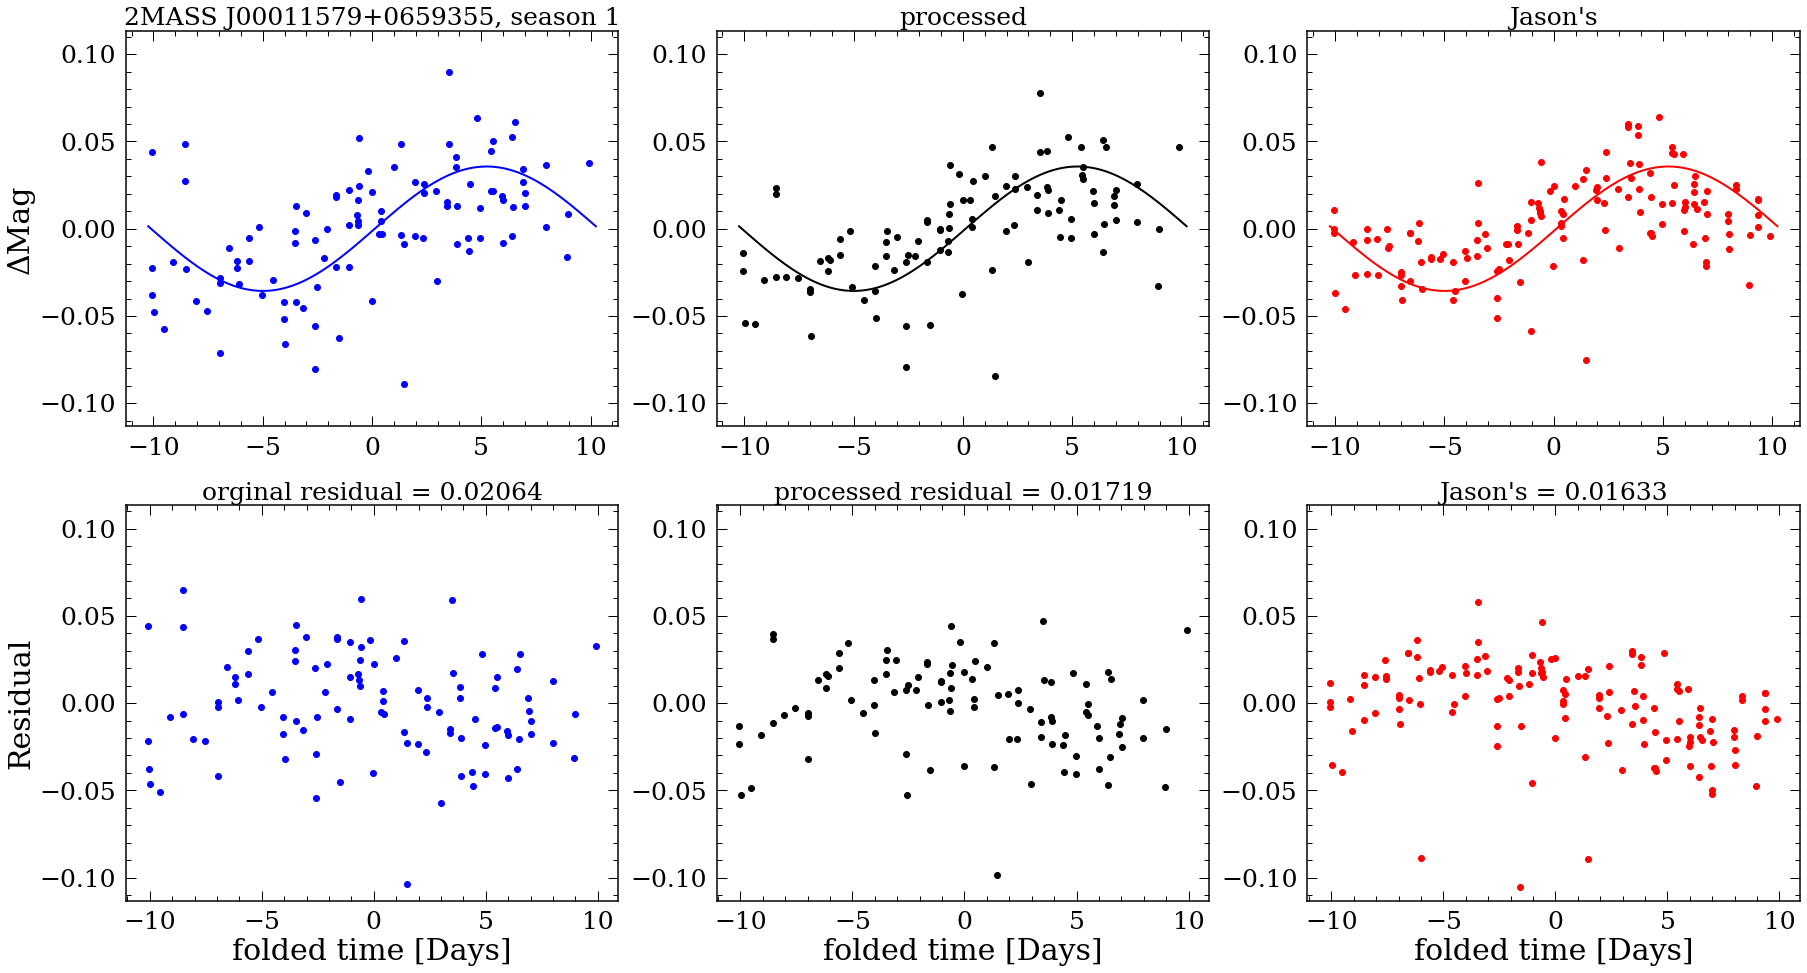

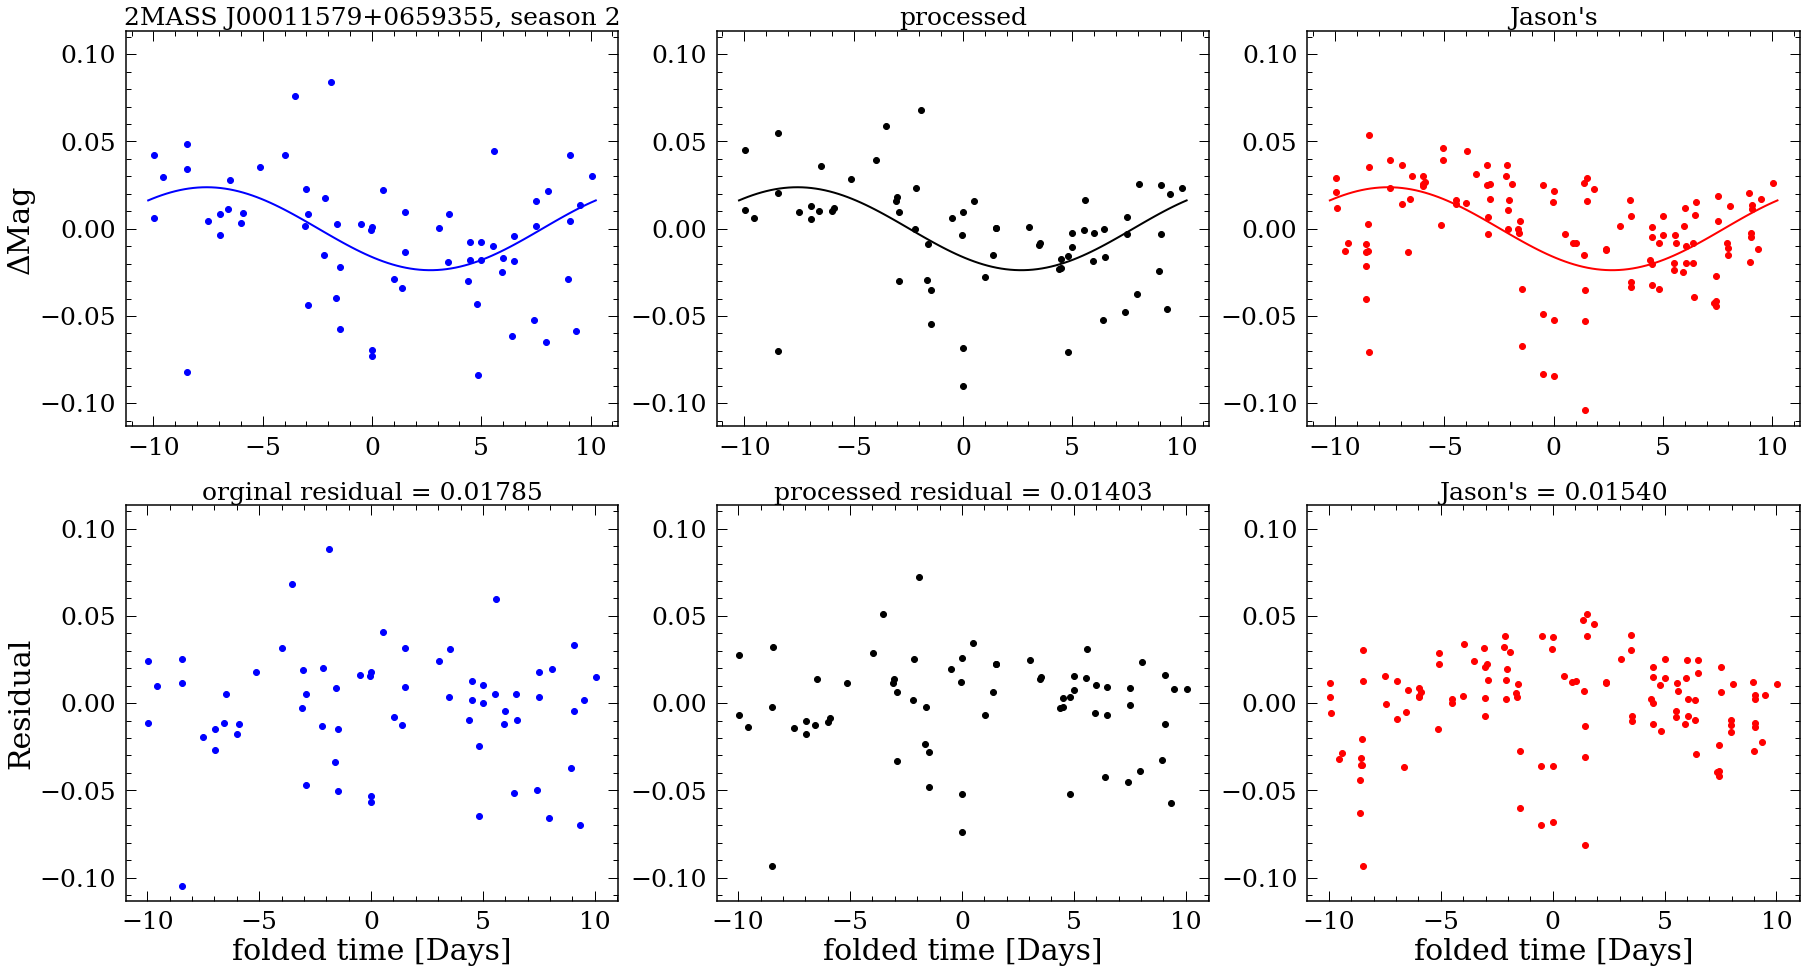

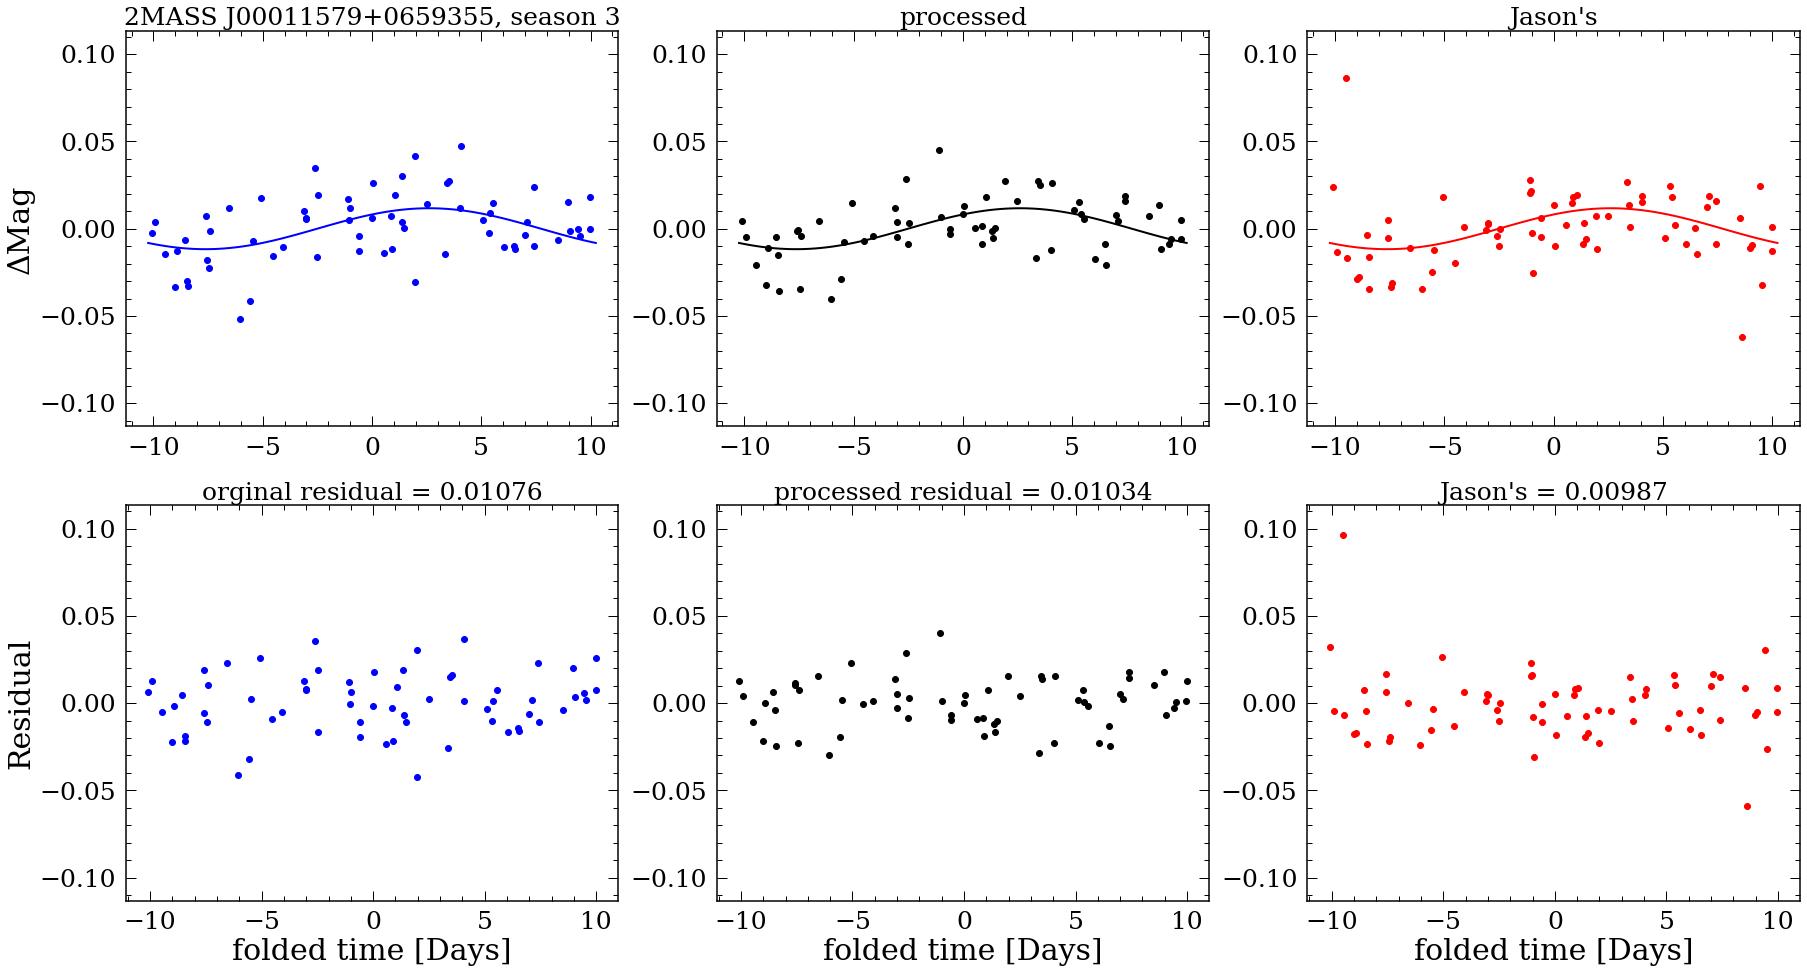

<Figure size 2160x576 with 0 Axes>

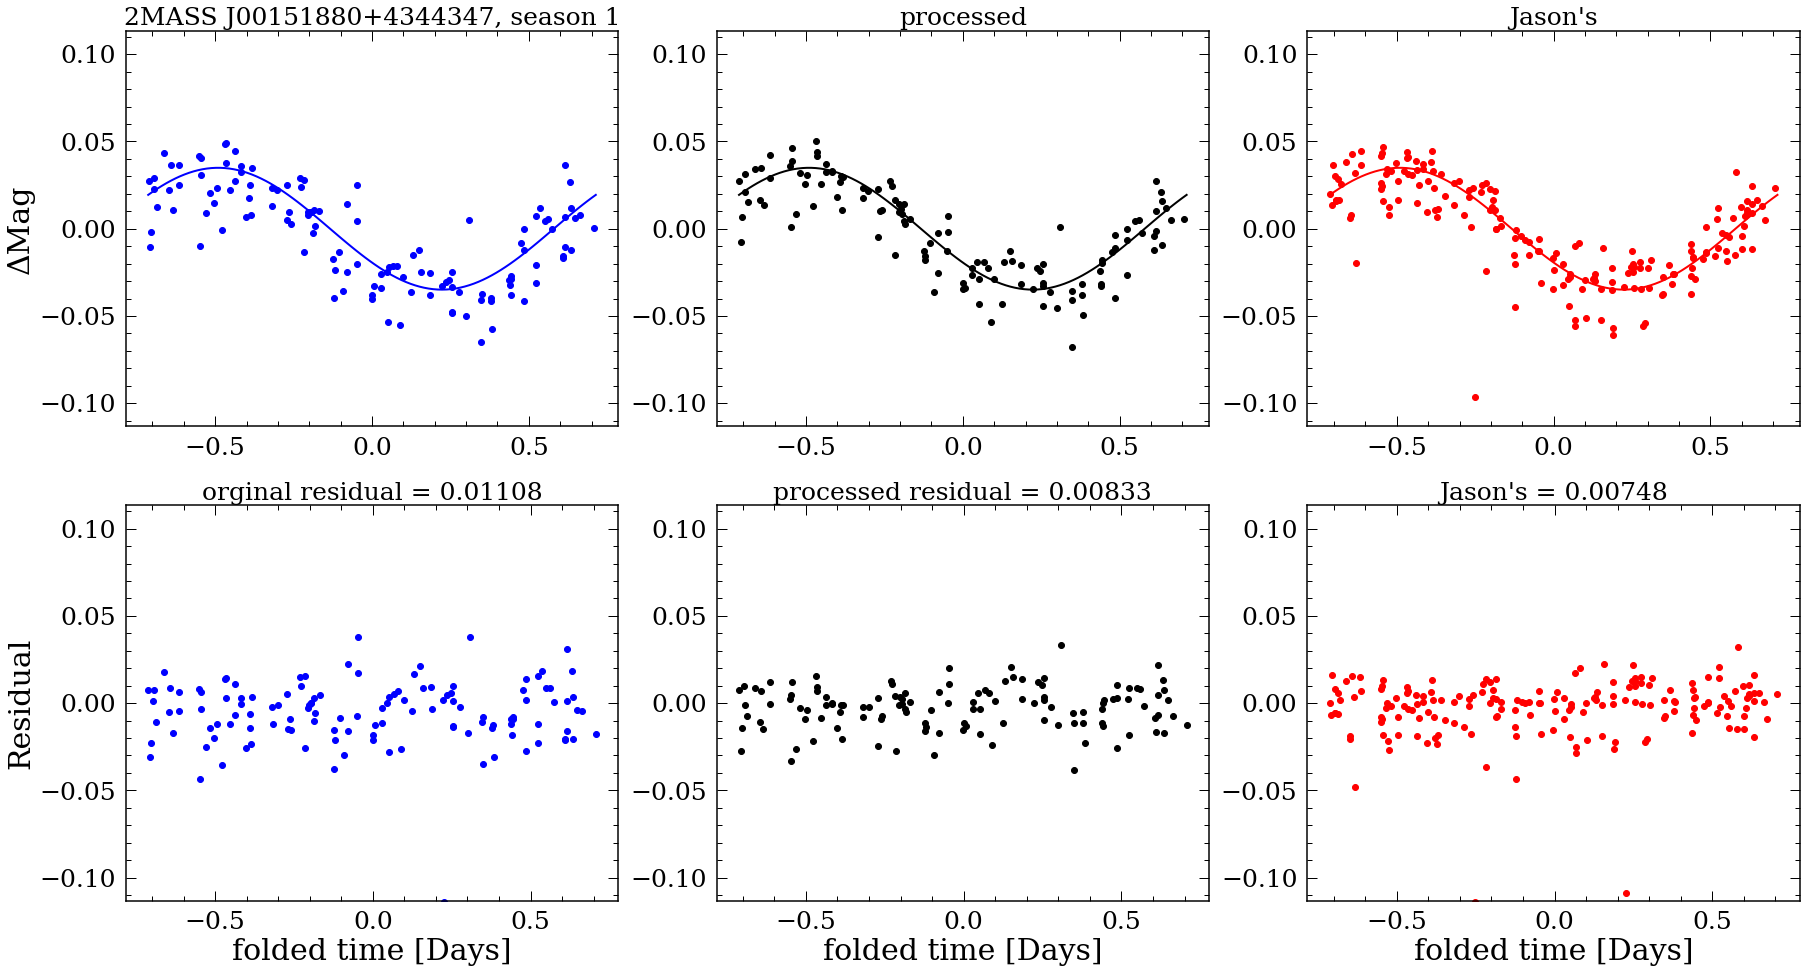

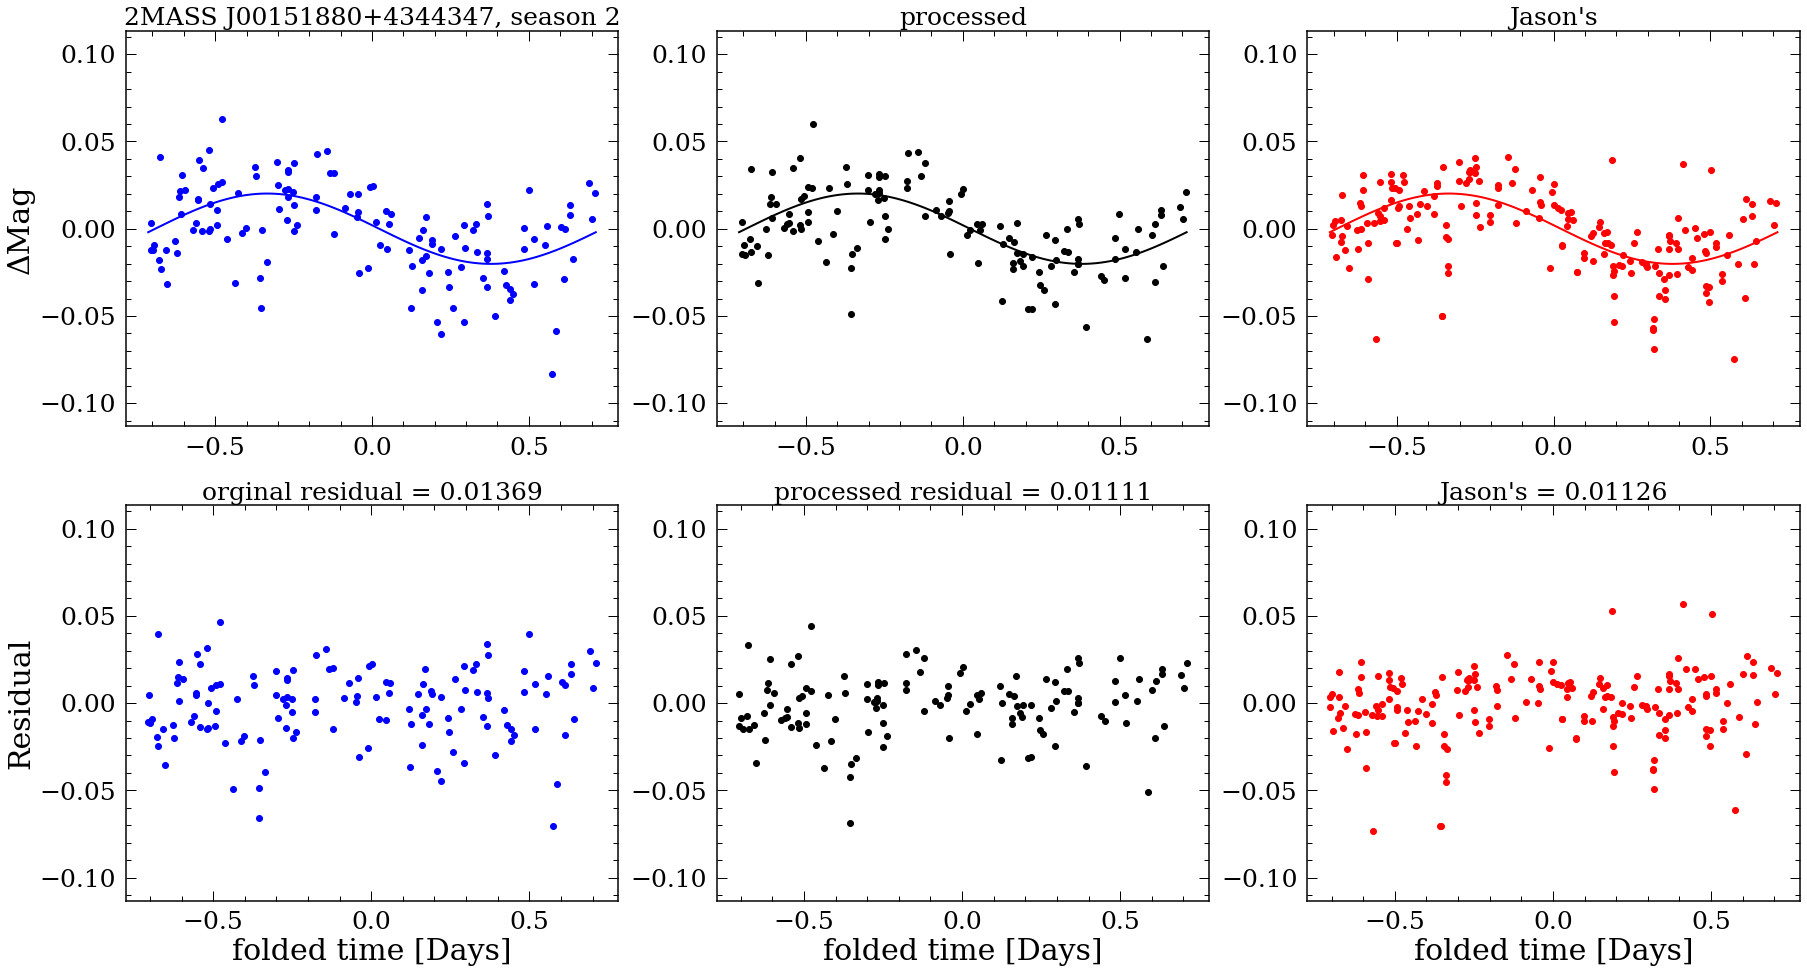

<Figure size 2160x576 with 0 Axes>

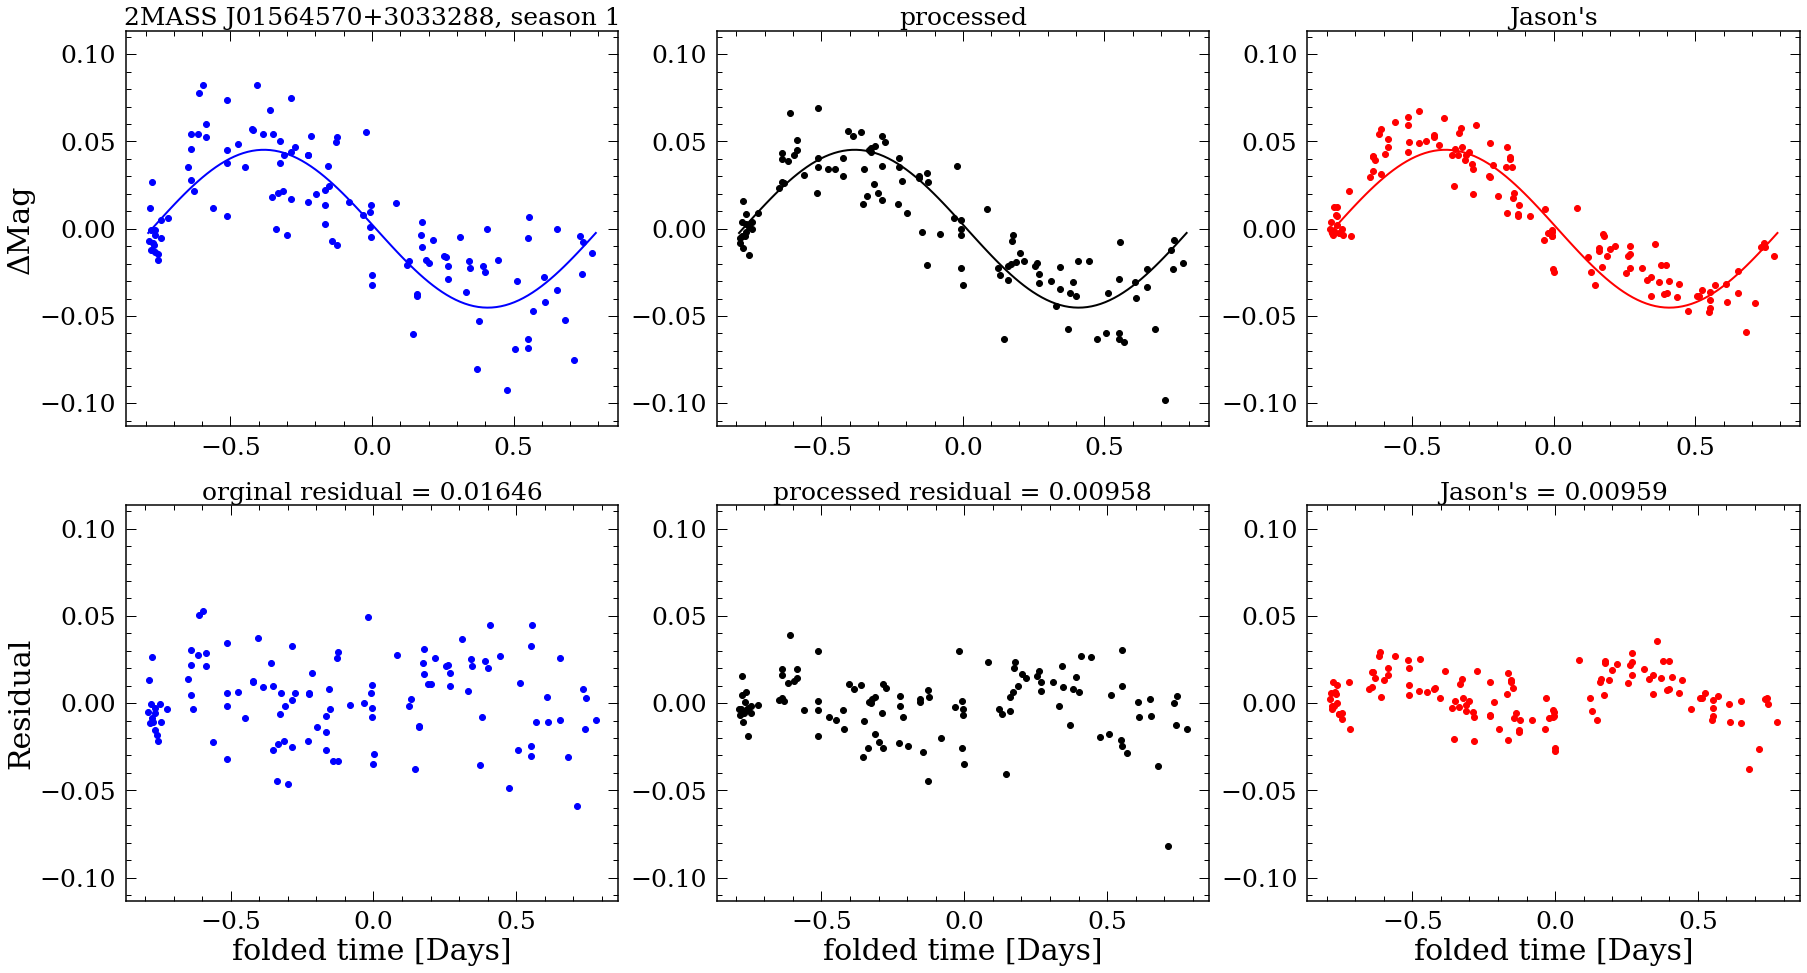

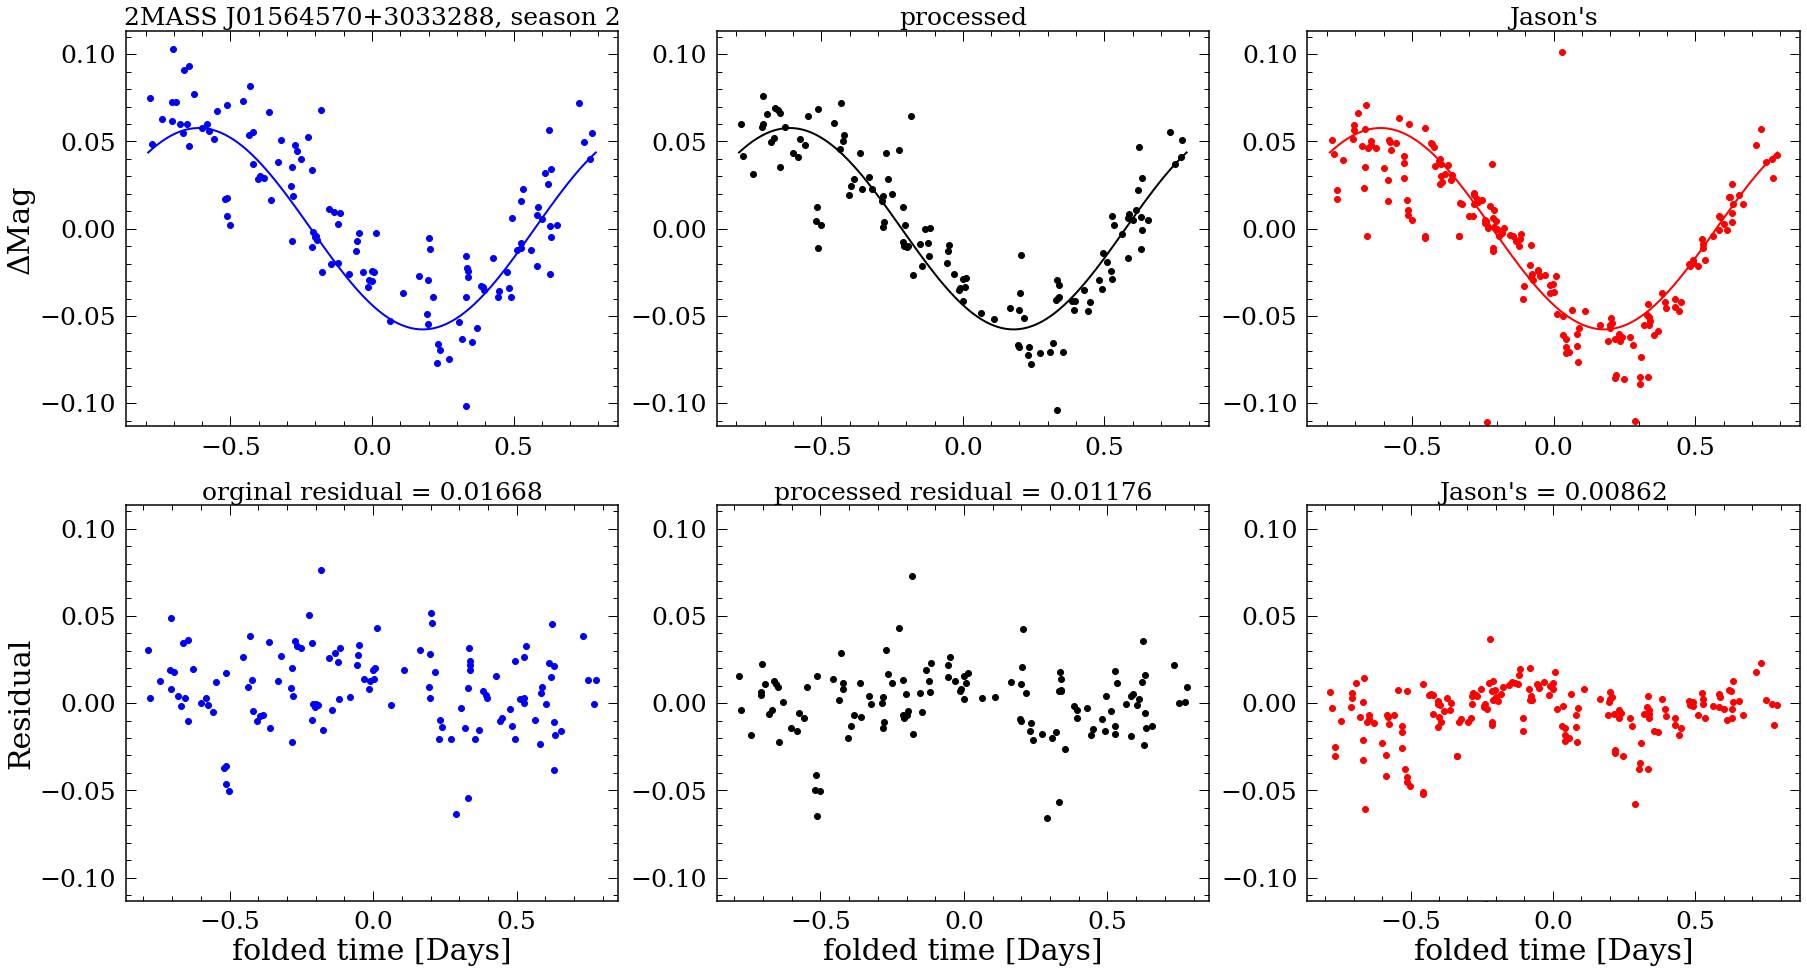

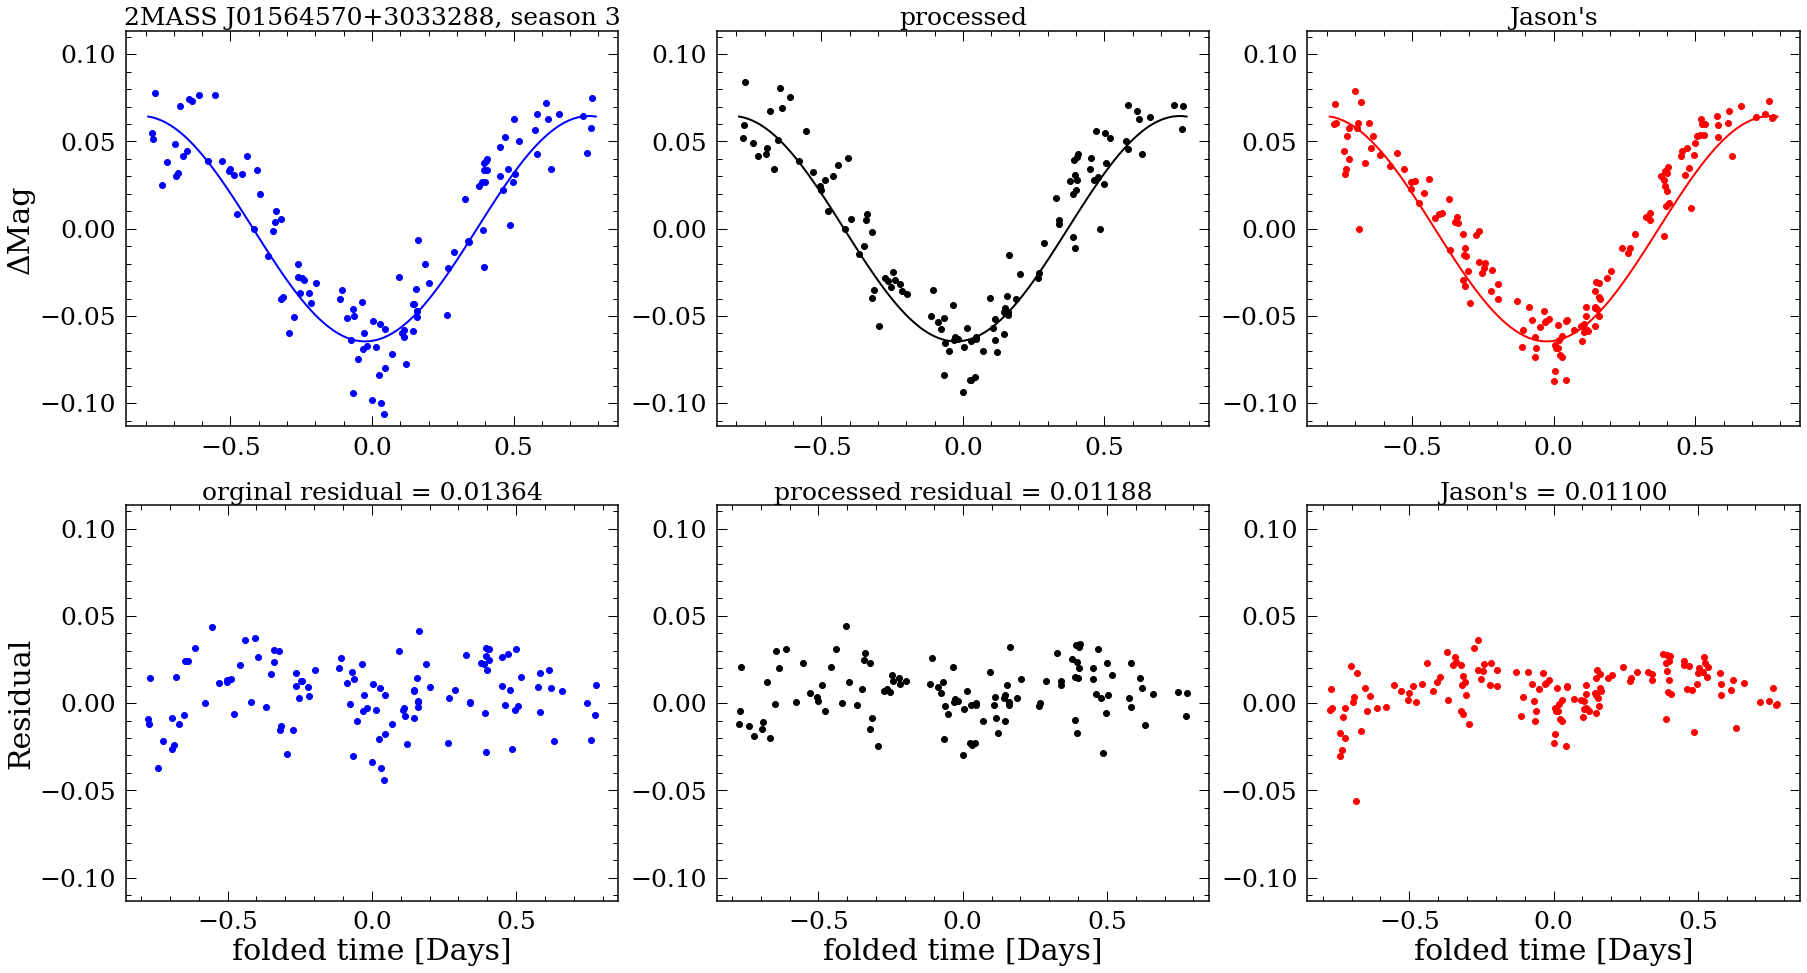

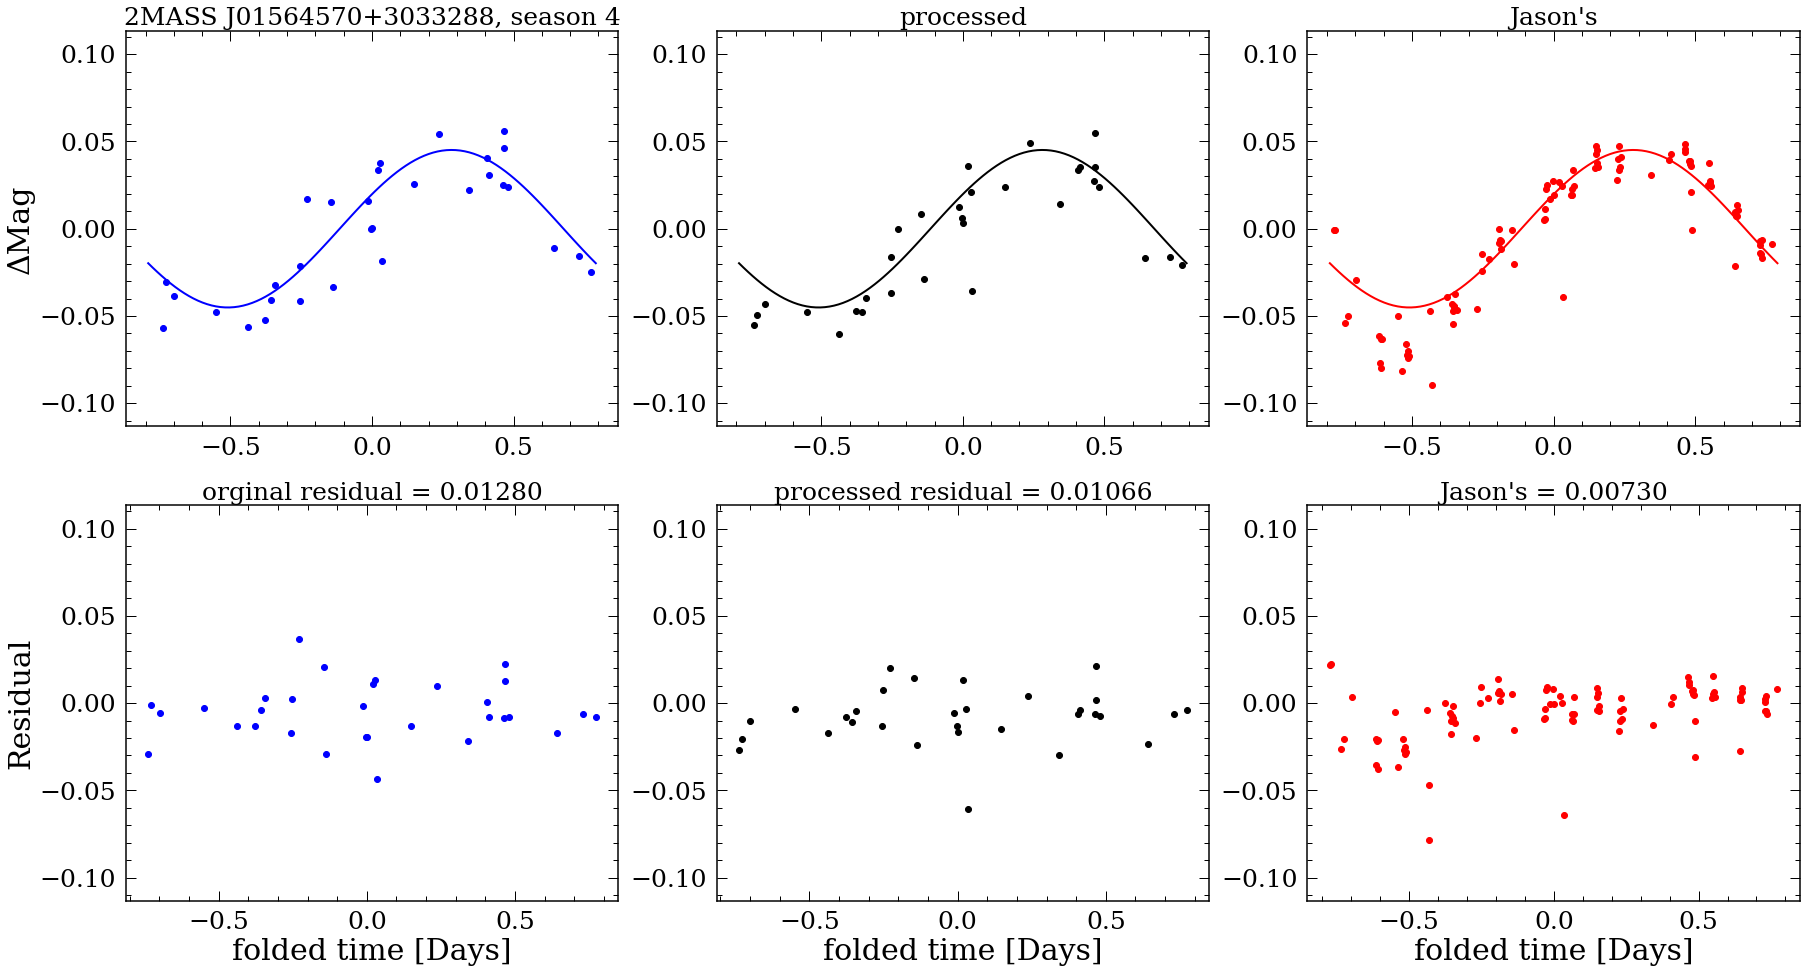

In [569]:
from scipy.optimize import curve_fit

season=1

mass2ids = []
orscatter = []
procscatter = []
jasonscatter = []
seasons = []

for i in trange(len(testlcs)):
    try:
        prots_test = prots.loc[prots['2MASS']==testlcs[i]]
        ra = prots_test['RA'].values[0]
        dec = prots_test['Dec'].values[0]
        gaiadr3 = prots_test['gaiadr3'].values[0]
    except:
        continue
    
    p_mearth=prots_test['Prot'].values[0]
    def sin_prot(x, a, c, d):
        return a * np.sin(2*np.pi*x/p_mearth + c)
    
    mainlc = download_ztf_archive_lightcurves(ra,dec, sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'].values[0]].reset_index(drop=True)
    
    lctime_ors, lcmag_ors = mainlc['mjd'].values, mainlc['mag'].values
    lcmag_ors = lcmag_ors-np.median(lcmag_ors)
    
    
    lctimes, lcmags, normtime, nearbylcs_no = processlc([ra,dec], searchradius=4, magrange=2, pltorg=False, splitlc=True, 
                                                        autls=True,protmeas=np.linspace(1,200,500),savefigname=[])

    lctime_js, lcmags_js, p_j, maxpower, medpower = ls_multi(gaiadr3, normalizetime=normtime, pltorg=False, splitlc=True)
    
    lctime_ors = lctime_ors-normtime
    
    for j in range(1, len(lctimes)):
        if testlcs[i] == 'J00151880+4344347':
            if j==3 or j==4:
                continue
        season = j
        lctime, lcmag = lctimes[season], lcmags[season]
        lctime_j, lcmags_j = lctime_js[season], lcmags_js[season]

        m = (lctime_ors>=min(lctime))&(lctime_ors<=max(lctime))

        lctime_or, lcmag_or = lctime_ors[m], lcmag_ors[m]
        lcmag_or = lcmag_or-np.median(lcmag_or)
        lcmags_j = lcmags_j-np.median(lcmags_j)
        fflc = np.median(lctime_or)
        lctime_or, lcmag_or = pf(lctime_or, lcmag_or, p_mearth)
        lctime, lcmag = pf(lctime, lcmag, p_mearth, medlctime=fflc)
        lctime_j, lcmags_j = pf(lctime_j, lcmags_j, p_mearth, medlctime=fflc)


        ylims = np.std(lcmags_or)
        plt.figure(figsize=(30,16))
        tsim = np.linspace(-p_mearth/2,p_mearth/2,100)
        plt.subplot(2,3,1)
        popt, pcov = curve_fit(sin_prot, lctime_or, lcmag_or)
        plt.plot(lctime_or,lcmag_or ,'bo')
        plt.plot(tsim,sin_prot(tsim, *popt) ,'b-')
        plt.title('2MASS '+testlcs[i]+', season '+str(season),fontsize=25)
        plt.ylim([-ylims,ylims])
        plt.ylabel('ΔMag')

        
        plt.subplot(2,3,2)
        plt.plot(lctime, lcmag, 'ko')
        plt.plot(tsim,sin_prot(tsim, *popt) ,'k-')
        plt.title('processed',fontsize=25)
        plt.ylim([-ylims,ylims])


        plt.subplot(2,3,3)
        try:
            plt.plot(lctime_j, lcmags_j, 'ro')
            plt.plot(tsim,sin_prot(tsim, *popt) ,'r-')
            plt.title("Jason's",fontsize=25)
            plt.ylim([-ylims,ylims])

            plt.subplot(2,3,6)
            plt.plot(lctime_j, lcmags_j-sin_prot(lctime_j, *popt), 'ro')
            scatter_Jason = np.median(abs(lcmags_j-sin_prot(lctime_j, *popt)))
            plt.title("Jason's = %.5f"%(scatter_Jason),fontsize=25)
            plt.ylim([-ylims,ylims])
            plt.xlabel('folded time [Days]')
            
            jasonscatter.append(scatter_Jason)
        except:
            pass


        plt.subplot(2,3,4)
        plt.plot(lctime_or,lcmag_or-sin_prot(lctime_or, *popt) ,'bo')
        scatter_or = np.median(abs(lcmag_or-sin_prot(lctime_or, *popt)))
        plt.title('orginal residual = %.5f'%(scatter_or),fontsize=25)
        plt.ylim([-ylims,ylims])
        plt.xlabel('folded time [Days]')
        plt.ylabel('Residual')

        plt.subplot(2,3,5)
        plt.plot(lctime, lcmag-sin_prot(lctime, *popt), 'ko')
        scatter_process = np.median(abs(lcmag-sin_prot(lctime, *popt)))
        plt.title('processed residual = %.5f'%(scatter_process),fontsize=25)
        plt.ylim([-ylims,ylims])
        plt.xlabel('folded time [Days]')

        mass2ids.append(testlcs[i])
        orscatter.append(scatter_or)
        procscatter.append(scatter_process)
        
        seasons.append(season)

    
    clear_output(wait=True)
    





In [570]:
df_scatter = pd.DataFrame(np.array((mass2ids, seasons, orscatter, procscatter, jasonscatter)).T,
                         columns=[['2MASS','season','scatter_or','scatter_proc','scatter_jason']])


In [571]:
for i in ['season','scatter_or','scatter_proc','scatter_jason']:
    df_scatter[i] = np.array(df_scatter[i].values, dtype=float)

In [572]:
print(np.std(df_scatter['scatter_or']),np.std(df_scatter['scatter_proc']),np.std(df_scatter['scatter_jason']))


scatter_or    0.003099
dtype: float64 scatter_proc    0.002465
dtype: float64 scatter_jason    0.003026
dtype: float64


# typical cadence 

100%|██████████| 3/3 [00:00<00:00, 212.87it/s]


(array([343.,   0.,   2., 346.,  45.,   0.,   4., 210.,   3.,   0.,   8.,
        137.,   0.,   0.,  10.,  43.,   0.,   0.,  17.]),
 array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
        1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
        2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
        3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ]),
 <BarContainer object of 19 artists>)

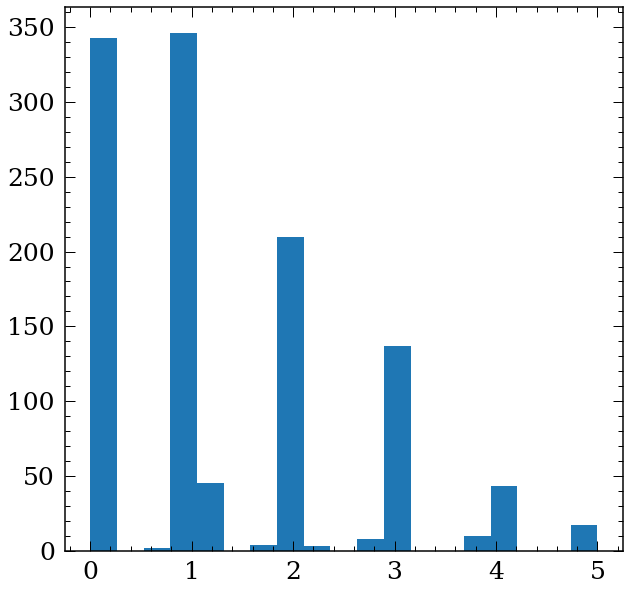

In [577]:
allcadence = np.ones(1)
for i in trange(len(testlcs)):
    prots_test = prots.loc[prots['2MASS']==testlcs[i]]
    ra = prots_test['RA'].values[0]
    dec = prots_test['Dec'].values[0]
    gaiadr3 = prots_test['gaiadr3'].values[0]
    
    mainlc = download_ztf_archive_lightcurves(ra,dec, sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'].values[0]].reset_index(drop=True)
    
    allcadence = np.append(allcadence, np.diff(sorted(mainlc['mjd'].values)))

plt.hist(allcadence[1:], bins=np.linspace(0,5,20))
    


100%|██████████| 137/137 [00:00<00:00, 1053.64it/s]


LG orginal lcs...


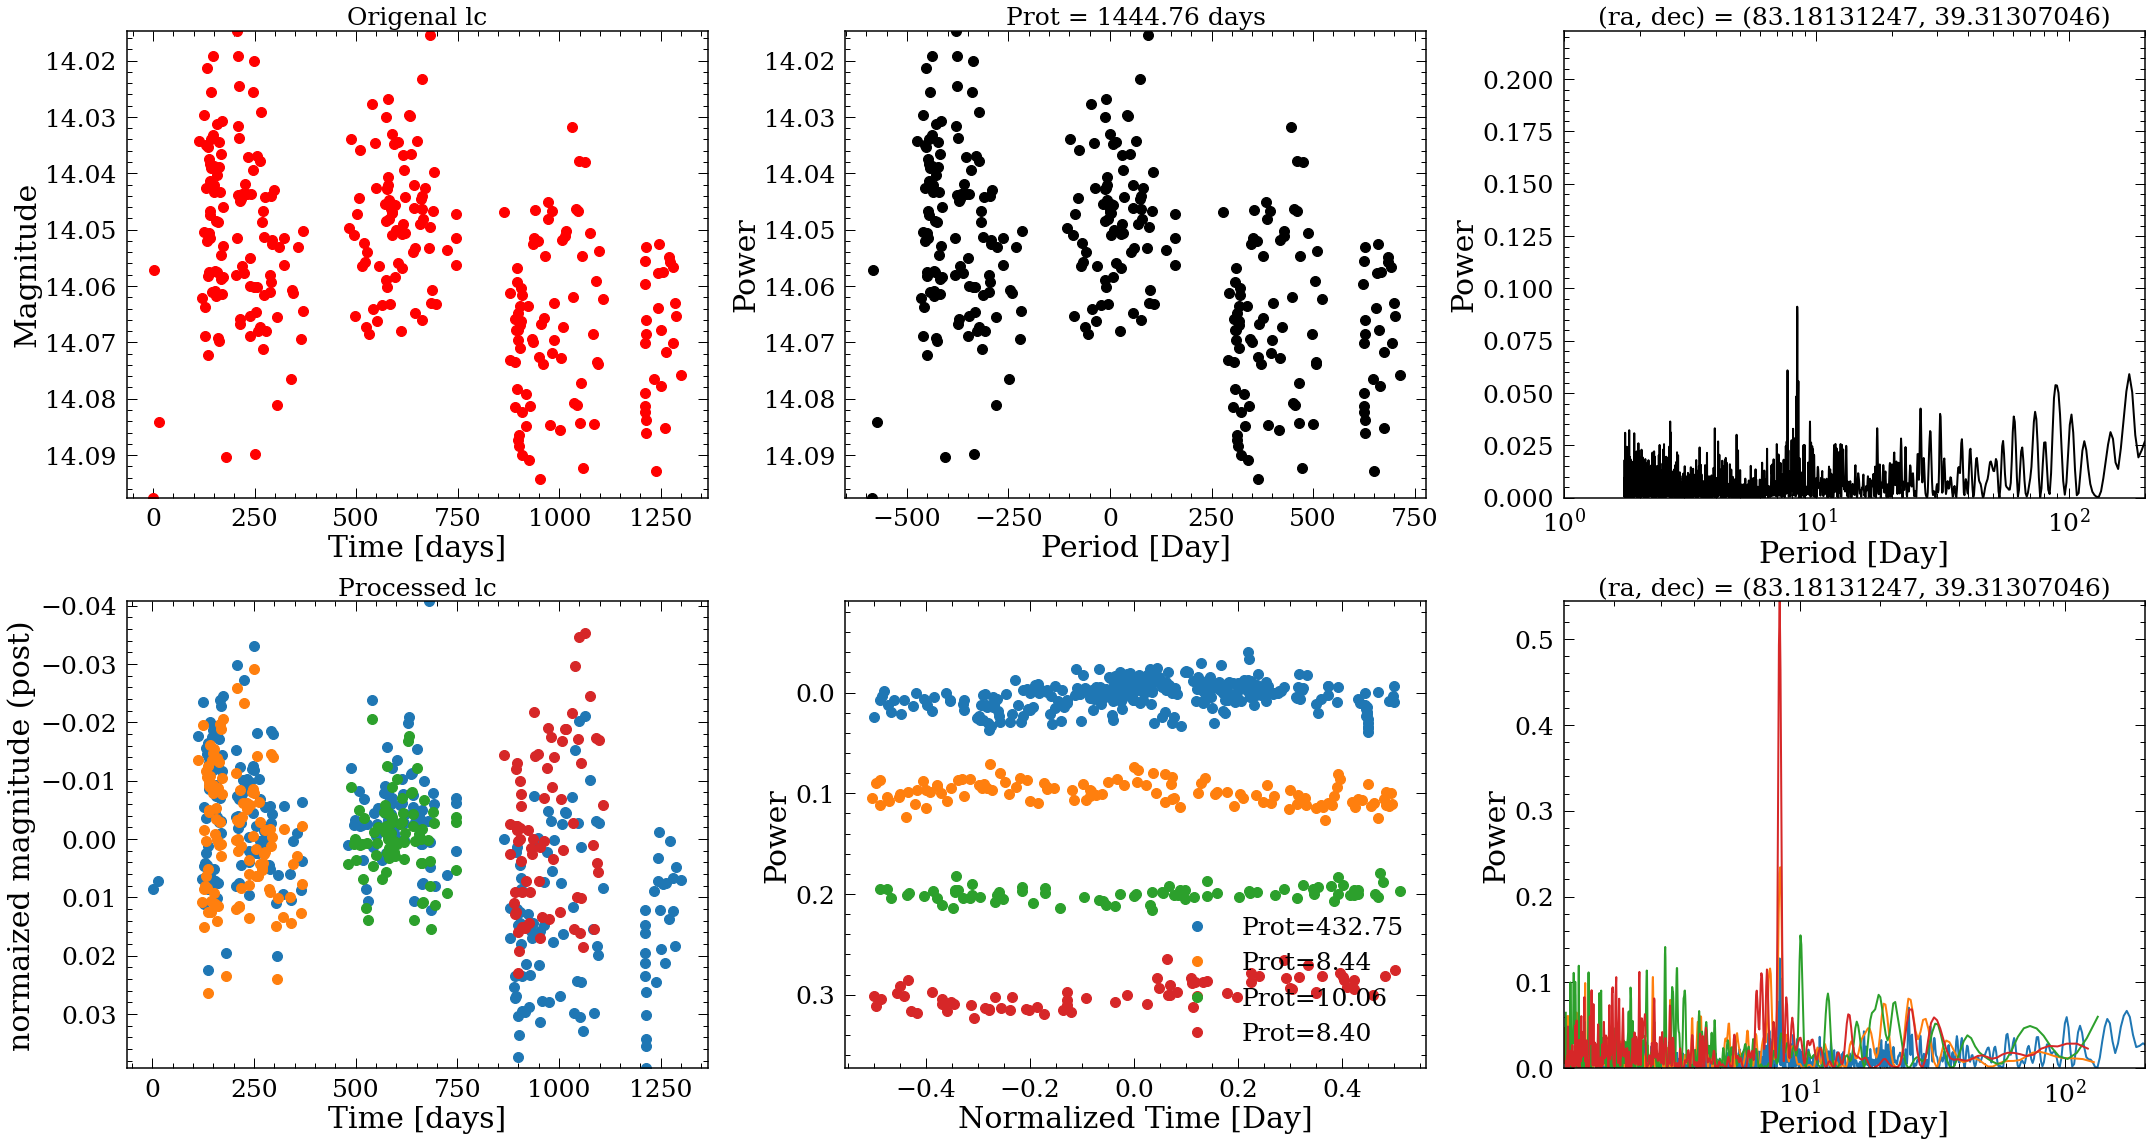

In [588]:
lctimes, lcmags, normtime, nearbylcs_no = processlc([83.18131247,39.31307046], searchradius=4, magrange=2, pltorg=True, splitlc=True, 
                                                        autls=True,protmeas=np.linspace(1,200,500),savefigname=[])



splitting into 4 lcs...
LG post processed lcs...


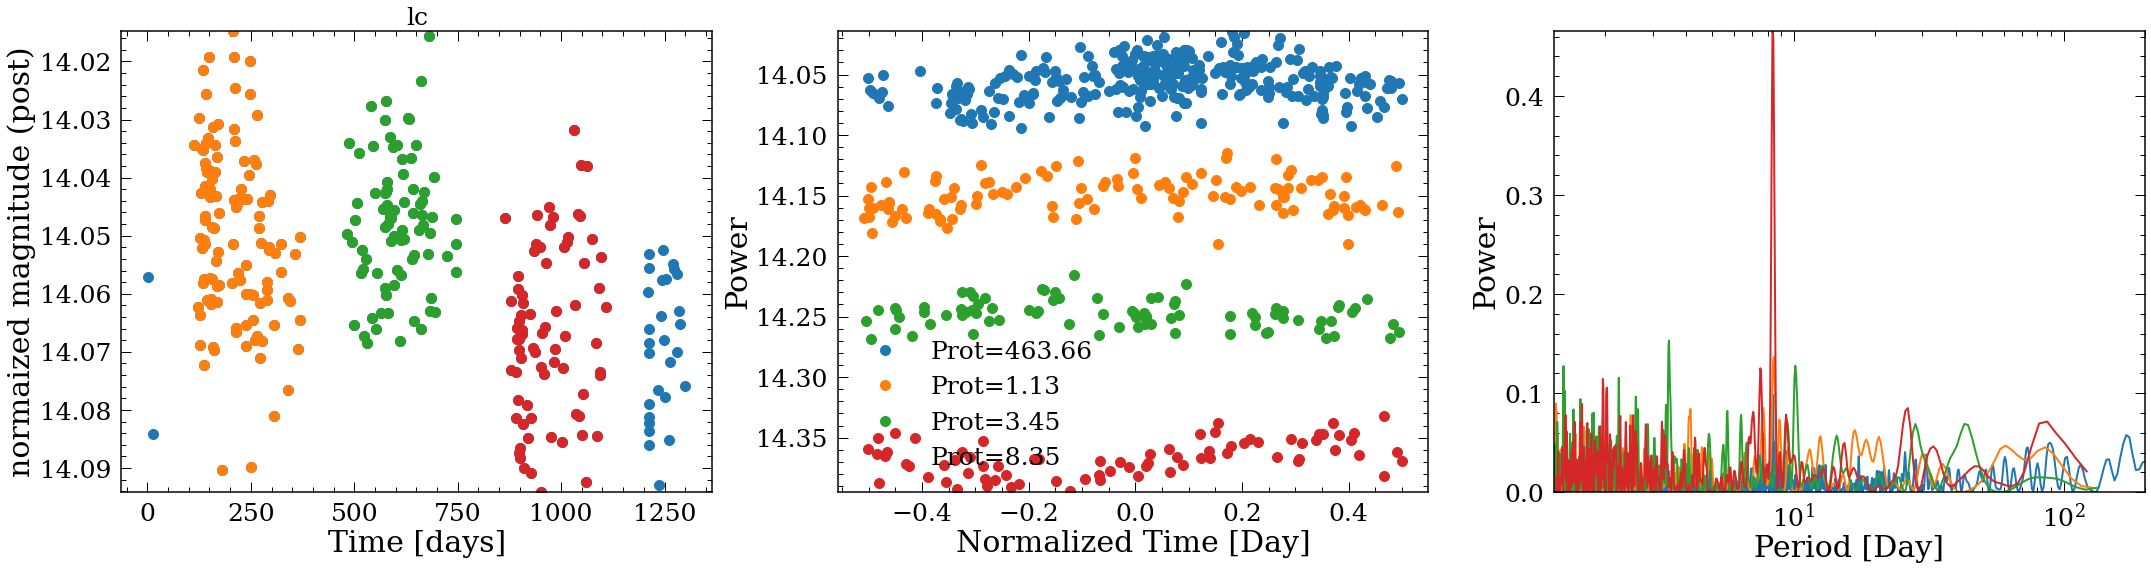

In [600]:
lctime_sing, lcmags_sing, Ps, bestpower, medpower = ls_orginal([83.18131247,39.31307046], pltorg=True, splitlc=True, autls=True,
                                     protmeas=np.linspace(1,200,500))
    
